### **Data Preparing and Modeling Notebook**

**Overview:**
As a photography enthusiast, I am interested in building an photography genre image classification for landscape and portrait. This project's target is a bianry output. 0 being landscape and 1 being portrait.


**Business Problem:**
The photography classification can aid in organizing and categorizing artworks, creating thematic exhibitions, and conducting research on specific genres. It also helps organize and categorize independent photographers' own images, improve search and discovery, and gain insights into popular genres.
An accurate genre classification can enhance online photography platforms by improving search functionality, enabling better content recommendations, and enhancing user experience.

**Stakeholder:**
Curators and Art Galleries, online photography platform, and photographers.

**Data:**
10K images in total. 5000 Portrait images from Unsplash, 5000 landscape images combined from Kaggle dataset and Unsplash.






Import libraries

In [127]:
# Import analysis libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

#Import image data
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
#from tf.keras.preprocessing import smart_resize
#from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image
import random
import pickle
import cv2
import os

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score

#KERAS
from keras import callbacks
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
# import data from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


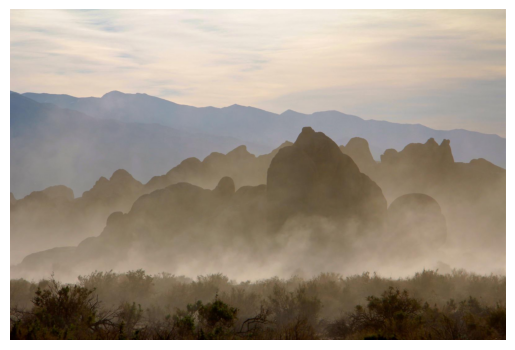

In [ ]:
# check an image of landscape
image_path = '/content/drive/MyDrive/data/landscape/00000761.jpg'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()




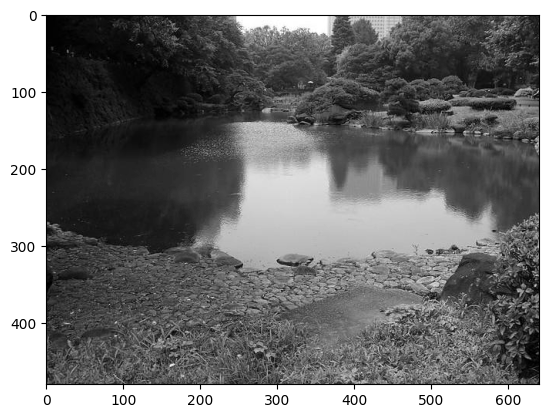

In [ ]:
DATADIR = "/content/drive/MyDrive/data"
CATEGORIES = ["landscape","portrait"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap ='gray')
    plt.show()
    break
  break


In [ ]:

print(img_array)

[[  2   2   2 ...  29  37  51]
 [  2   2   2 ...  44  40  39]
 [  2   2   2 ...  47  44  37]
 ...
 [ 97  78  88 ... 103  95  36]
 [ 88  93 111 ...  76  34   0]
 [ 53  72  91 ...  83  35  31]]


In [ ]:
img_array.shape

(480, 640)

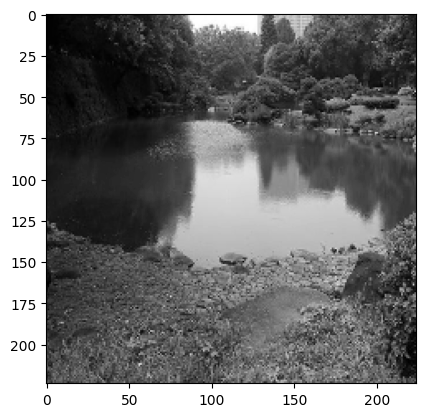

In [ ]:
# change size of the image and see how it looks, revise img_size...
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [ ]:
# create a training set with all 60 landscape and 60 portraits and reshape them to 224 x 224, grayscaled
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category) # labels the data to 0 and 1
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resize
        training_data.append([new_array, class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
print(len(training_data))

120


In [ ]:
import random
random.shuffle(training_data)

In [ ]:
for sample in training_data[:10]:
  print(sample[1])

0
1
1
1
0
0
1
0
0
1


In [ ]:
X = []
y = []

In [ ]:
for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1) #1 is for gray scale, 3 is for colored

In [ ]:
# create separate files for features and targets

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


In [ ]:
X = pickle.load(open("X.pickle", 'rb'))
y = pickle.load(open("y.pickle", 'rb'))

In [ ]:
# Normalize data
X = X/255.0

In [ ]:
X.shape

(120, 224, 224, 1)

In [ ]:
len(y)

120

In [ ]:
y = np.array(y)

In [40]:
# Get the unique values and their counts
unique_values, value_counts = np.unique(y, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 60
1: 60


Train test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Start CNN modeling!

In [53]:
# Create the convolutional base
model = Sequential()
model.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape= X.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add Dense layers on top
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
# fit the model
results = model.fit(X_train, y_train, epochs = 10, batch_size = 15, validation_data = [X_test, y_test])

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 2.5963 - accuracy: 0.4375 - val_loss: 0.7183 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.6620 - accuracy: 0.5833 - val_loss: 0.6569 - val_accuracy: 0.6250
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.6256 - accuracy: 0.7708 - val_loss: 0.6305 - val_accuracy: 0.5417
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.4518 - accuracy: 0.7917 - val_loss: 0.4514 - val_accuracy: 0.8333
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.2204 - accuracy: 0.8854 - val_loss: 0.7059 - val_accuracy: 0.7083
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.1586 - accuracy: 0.9375 - val_loss: 0.3116 - val_accuracy: 0.8333
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.0590 - accuracy: 0.9896 - val_loss: 0.2337 - val_accuracy: 0.9167
Epoch 8/10
7/7 [=====================

In [54]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7f208a6a7d90>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [2.5963294506073,
   0.6619950532913208,
   0.6255876421928406,
   0.4518236815929413,
   0.22044110298156738,
   0.15864066779613495,
   0.05899665877223015,
   0.032157789915800095,
   0.02430516481399536,
   0.0528063029050827],
  'accuracy': [0.4375,
   0.5833333134651184,
   0.7708333134651184,
   0.7916666865348816,
   0.8854166865348816,
   0.9375,
   0.9895833134651184,
   0.9895833134651184,
   0.9895833134651184,
   0.9791666865348816],
  'val_loss': [0.7183043360710144,
   0.6568616032600403,
   0.630455732345581,
   0.45136332511901855,
   0.7059495449066162,
   0.3116498291492462,
   0.23365338146686554,
   0.26475098729133606,
   0.2577918469905853,
   0.6938425898551941],
  'val_accuracy': [0.5,
   0.625,
   0.5416666865348816,
   0.8333333134651184,
   0.7083333134651184,
   0.8333333134651184,
   0.91

Visualizations for loss and accuracy comparing training and testing

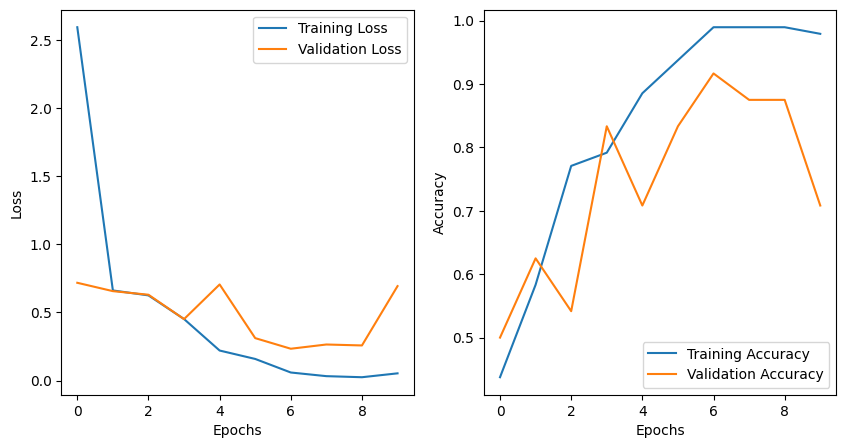

In [56]:
train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

val_loss = results.history['val_loss']
val_accuracy = results.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()



In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 531ms/step - loss: 0.6938 - accuracy: 0.7083


In [87]:
y_pred = model.predict(X_test[21].reshape(1, 224, 224, 1))
y_pred

1/1 [==============================] - 0s 55ms/step


array([[0.9663672]], dtype=float32)

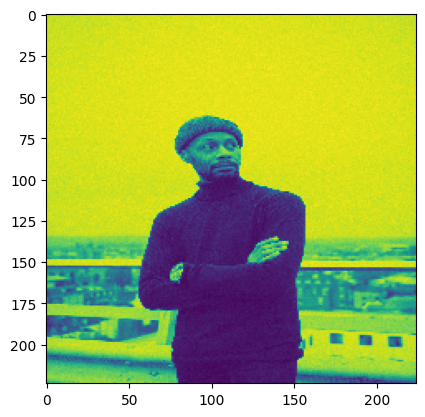

In [88]:
plt.imshow(X_test[21].reshape(224, 224))

This first model is extremely overfit comparing its loss and accuracy between training and testing results. This might cause by small dataset in hand.

Ways to improve:
1. Use Augmentation to increase the diversity of the training data.
2. Add regularizations (L1 and L2) and dropout
3. Reduce image size
4. Add early stopping
5. Model complexity reduction: decreasing the number of layers, reducing the number of filters, or using smaller filter sizes.

### Add Augmentation

In [98]:
# add early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=1, mode='min', patience=5)

In [114]:
# define augmentation parameters
aug = ImageDataGenerator(
    rotation_range=20, # rotate images randomly up to 20 degrees
    width_shift_range=0.2, #shift image horizontally by a fraction of the total width
    height_shift_range=0.2, #shift image vertically by a fraction of the total height
    brightness_range=None,
    shear_range=0.2, # apply shear transformation
    zoom_range=0.2, # zoom in / out on image
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip= True,
    vertical_flip= True
)

# Apply augmentation on training data
train_generator = aug.flow(X_train, y_train, batch_size = 15)

# Use fit_generator to fit the training data with augmentation
results = model.fit_generator(train_generator,
          steps_per_epoch = len(X_train) // 15,
          epochs = 20,
          validation_data = (X_test, y_test),
          callbacks = [early_stop])

Epoch 1/20


<ipython-input-114-830ae8f63b6e>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator,


6/6 [==============================] - 8s 1s/step - loss: 0.2746 - accuracy: 0.9259 - val_loss: 0.1330 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 9s 2s/step - loss: 0.2082 - accuracy: 0.9383 - val_loss: 0.1349 - val_accuracy: 0.9583
Epoch 3/20
6/6 [==============================] - 9s 1s/step - loss: 0.1967 - accuracy: 0.9383 - val_loss: 0.2723 - val_accuracy: 0.9167
Epoch 4/20
6/6 [==============================] - 9s 1s/step - loss: 0.2404 - accuracy: 0.9383 - val_loss: 0.1160 - val_accuracy: 0.9583
Epoch 5/20
6/6 [==============================] - 10s 2s/step - loss: 0.2684 - accuracy: 0.9444 - val_loss: 0.1099 - val_accuracy: 0.9583
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.1891 - accuracy: 0.9136 - val_loss: 0.3543 - val_accuracy: 0.9167
Epoch 7/20
6/6 [==============================] - 9s 1s/step - loss: 0.3858 - accuracy: 0.8642 - val_loss: 0.1580 - val_accuracy: 0.9583
Epoch 8/20
6/6 [==============================] - 9

With early stop and augmentation, the result improves extremely! Augmentation does reduce overfitting!




# VISUALIZATION:

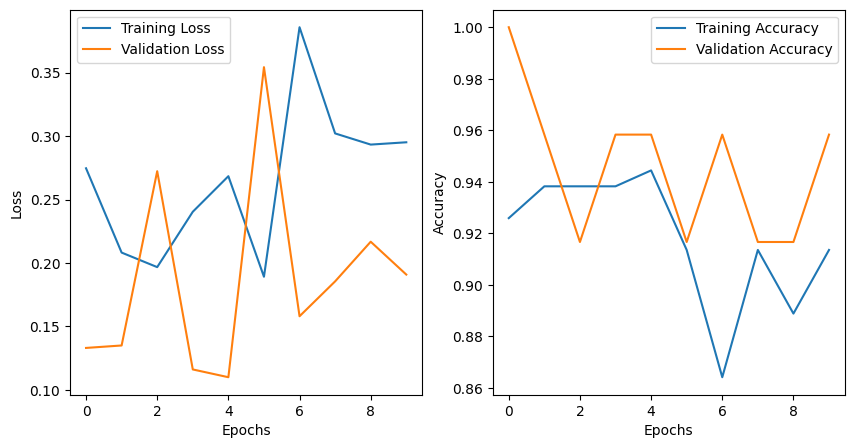

In [115]:
train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

val_loss = results.history['val_loss']
val_accuracy = results.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Do a predict on an image.

In [116]:
y_pred = model.predict(X_test[14].reshape(1, 224, 224, 1))
y_pred

1/1 [==============================] - 0s 40ms/step


array([[0.98653805]], dtype=float32)

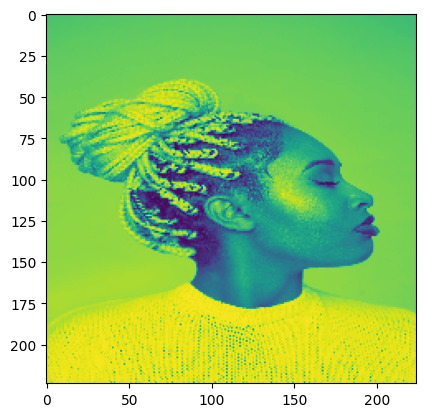

In [117]:
plt.imshow(X_test[14].reshape(224, 224))

In [118]:
y_pred = model.predict(X_test[8].reshape( 1,224, 224, 1))
y_pred

1/1 [==============================] - 0s 39ms/step


array([[0.35845667]], dtype=float32)

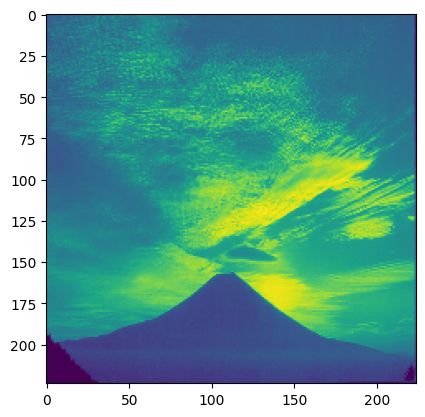

In [119]:
plt.imshow(X_test[8].reshape(224, 224))

In [129]:
#model.save("augmented_model1.h5")


In [130]:
# Save the augmentation configuration
# with open("augmentation_config1.pkl", "wb") as file:
    # pickle.dump(aug, file)

In [131]:
# Load the augmentation configuration
with open("augmentation_config1.pkl", "rb") as file:
    aug = pickle.load(file)

In [132]:
!ls

augmentation_config1.pkl  drive        X.pickle
augmented_model1.h5	  sample_data  y.pickle
